## Paul's draft of the IACS 2019 interpretability + fairness workshop

In [1]:
# Imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import eqtools as eq 

sns.set_palette('Set3', color_codes=True)
%matplotlib inline

Using TensorFlow backend.


### misc code 

In [196]:
def find_corr_feats(df, thresh=0.95):
    """ Function to drop linearly correalated features above a threshold of correlation 
    --------
    Args:
        df (pandas dataframe): DataFrame with at least two quantitative features
        thresh (float): the threshold of absolute pearson correlation to drop features above
    --------
    Returns: 
        (list) the feature names to drop 
    """
    # Correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix and find columns
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find cols to drop 
    to_drop = [column for column in upper.columns if any(upper[column] > thresh)]
    return to_drop

"""top_feats = ['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'fico_range_low',
       'mths_since_last_delinq', 'open_acc', 'revol_bal', 'revol_util',
       'total_acc']+['grade', 'emp_length', 'home_ownership', 'verification_status',\
        'zip_code','disbursement_method']
new_df2 = new_df[top_feats].copy(deep=True)
new_df2.isnull()"""
"""
to_drop = find_corr_feats(df, thresh=0.9)
new_df = df.drop(to_drop, axis=1)
"""
"""from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

s_df = new_df.sample(int(len(new_df)*.2), random_state=42)
df_x = s_df.drop(list(df.dtypes[df.dtypes==object].index)+['loan_status'], axis=1)
df_y = s_df['loan_status']

xtr, xte, ytr, yte = train_test_split(df_x, df_y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
sfm = SelectFromModel(clf, threshold='median')
sfm.fit(xtr, ytr)

df_x.columns[sfm.get_support(indices=True)]"""
import eqtools as eq
import importlib as imp
imp.reload(eq)
import eqtools as eq
%load_ext autoreload
%autoreload 2

## Load the (relatively) cleaned data

We are using data from LendingClub which you can download [here](https://drive.google.com/file/d/1yVUnuSA19CHyLbeyfCkunp5AGKzyBKLx/view?usp=sharing).   

This data covers LendingClub's open peer-to-peer lending data from 2012 to 2018.  The dataset contains features about the borrower, and each row represents a loan.  The data can be downloaded in its raw form from LendingClub's website, but we have taken care of some data cleaning to streamline this tutorial.   

In [260]:
# Import cleaned data
df = pd.read_csv('../data/loans_data.csv')
print(f'We have {len(df)} rows.')
df.head()

We have 805148 rows.


loan_amnt  int_rate  annual_inc    dti  delinq_2yrs  fico_range_low  \
0     5000.0    0.1065     24000.0  27.65          0.0           735.0   
1     2500.0    0.1527     30000.0   1.00          0.0           740.0   
2     2400.0    0.1596     12252.0   8.72          0.0           735.0   
3    10000.0    0.1349     49200.0  20.00          0.0           690.0   
4     3000.0    0.1269     80000.0  17.94          0.0           695.0   

   inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  \
0             1.0               34.446551               70.816146       3.0   
1             5.0               34.446551               70.816146       3.0   
2             2.0               34.446551               70.816146       2.0   
3             1.0               35.000000               70.816146      10.0   
4             0.0               38.000000               70.816146      15.0   

        ...        emp_length  home_ownership  verification_status  zip_code  \
0       ...         10+ years            RENT             Verified     860xx   
1       ...          < 1 year            RENT      Source Verified     309xx   
2       ...         10+ years            RENT         Not Verified     606xx   
3       ...         10+ years            RENT      Source Verified     917xx   
4       ...            1 year            RENT      Source Verified     972xx   

   term  initial_list_status  disbursement_method  application_type  \
0    36                    f                 Cash        Individual   
1    60                    f                 Cash        Individual   
2    36                    f                 Cash        Individual   
3    36                    f                 Cash        Individual   
4    60                    f                 Cash        Individual   

   loan_status  age_of_cr_line  
0            1            34.0  
1            0            20.0  
2            1            18.0  
3            1            23.0  
4            1            23.0  

[5 rows x 33 columns]

### Seperate out into train and test

Here we define the column types and one hot encode the categorical variables for the ML algorithm

In [261]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# One hot encoding and subset into train/test 
quant_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',\
              'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec',\
              'revol_bal', 'revol_util', 'total_acc', 'acc_now_delinq', 'tot_coll_amt',\
              'tot_cur_bal', 'tax_liens', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',\
              'age_of_cr_line', 'installment']

cat_cols = ['grade','emp_length', 'home_ownership','verification_status', 'term', 'initial_list_status',\
            'disbursement_method', 'application_type']

other_cols = ['zip_code']
response_col = 'loan_status'

# data = df[quant_cols+cat_cols].copy(deep=True)
# response = df[response_col]

# preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), quant_cols),
#                                                ('cat', OneHotEncoder(), cat_cols)]).fit(data)


# cat_names = {}
# for feature in cat_cols:
#     le = LabelEncoder().fit(data.loc[:, feature])
#     data.loc[:, feature] = le.transform(data.loc[:, feature])
#     cat_names[feature] = le.classes_
    
# encoder = OneHotEncoder().fit(data)

df_x = pd.get_dummies(df[quant_cols+cat_cols], drop_first=False, columns=cat_cols)
# Standardize
# for q_col in quant_cols:
#     df_x.loc[:,q_col] = (df_x.loc[:,q_col] - df_x.loc[:,q_col].mean()) / df_x.loc[:,q_col].std()
df_y = df[response_col]

def get_ohe_col_names(preproc, c_cols):
    """ Helper to get the column names in a good format """
    cat_col_names = []
    for c in preprocessor.named_transformers_['cat'].get_feature_names():
        front = c_cols[int(c.split('_')[0].replace('x',''))]
        back = c.split('_')[1]
        cat_col_names.append(front+'_'+back)
    return cat_col_names

# x_train, x_test, y_train, y_test = train_test_split(data, response, test_size=0.33, random_state=42)

# ohe_col_names = get_ohe_col_names(preprocessor, cat_cols)
# new_col_names = quant_cols+ohe_col_names

# encoded_x_train = preprocessor.transform(x_train)
# encoded_x_test = preprocessor.transform(x_test)


x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42)

## Model Fitting 

Let's fit a model to the LendingClub data and see how well we do.  

We will use a Random Forest because it is a high-capacity model which cannot be explained trivially. 

!!!!!!!!!!!! NOTE: intentionally overfitting here... we'll present a more robust version of this model later in the notebook 

In [265]:
# Fit Model
# model = LogisticRegression(C=0.1, solver='liblinear', random_state=42).fit(x_train, y_train)
model = RandomForestClassifier(n_estimators=25, max_depth=None, #class_weight='balanced_subsample', \
                               random_state=42).fit(x_train, y_train)


Accuracy Train: 0.9977; Accuracy Test: 0.7959
AUC train: 1.0; AUC test: 0.6856


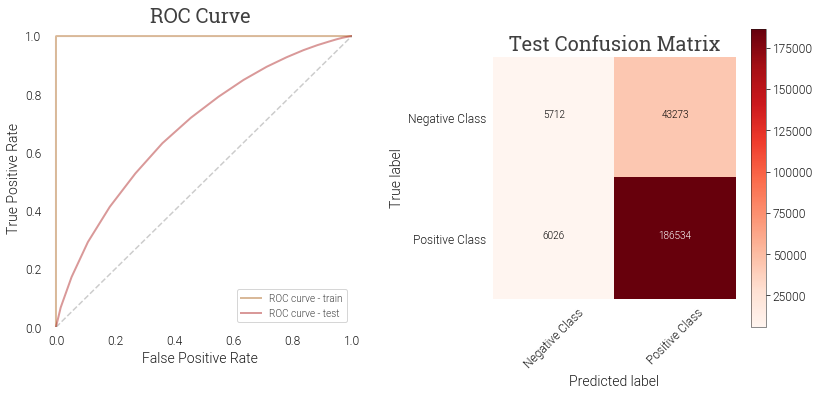

In [266]:
# print(f'Accuracy Train: {round(model.score(encoded_x_train, y_train),4)};',\
#       f'Accuracy Test: {round(model.score(encoded_x_test, y_test),4)}')
# eq.model.model_analysis(model, encoded_x_train, y_train, encoded_x_test, y_test, style='deck', figsize=(12,6));
print(f'Accuracy Train: {round(model.score(x_train, y_train),4)};',\
      f'Accuracy Test: {round(model.score(x_test, y_test),4)}')
eq.model.model_analysis(model, x_train, y_train, x_test, y_test, style='deck', figsize=(12,6));

## We have a model, so now what? 
- What do you see that could be a potential problem with this model? 
- How can we check to see *why* the model is making its decisions?

We can look at feature importances for the model because it's a tree-based ensemble.  Feature importances are good for a quick look but they can sometimes be [misleading](https://explained.ai/rf-importance/index.html).  Even if the calculated feature importances are faithful to the model's structure, we still do not know the importance of certain features for *individual* observations or *sub-groups* of observations.

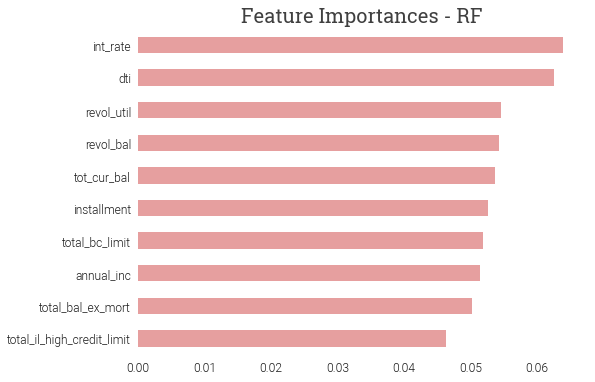

In [308]:
# fig, ax = plt.subplots(figsize=(8,6))
# feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
# ax = feat_importances.nlargest(10).sort_values().plot(kind='barh', color='r', alpha=0.6, ax=ax)
# ax.set_title('Feature Importances - RF');

# Eqtools version 
fig, ax = plt.subplots(figsize=(8,6))
eq.viz.explain_model(model, x_train.columns, style='deck', ax=ax);

### Local Interperetability 

We are going to focus on [LIME (Local Interperetable Model-agnostic Explainations)](https://github.com/marcotcr/lime) for our local interperatability section.  

LIME works by making a linear approximation to the model's decision boundary at the specified point and using the coefficients of the linear approximation to explain the model's behavior at that point.  This means LIME is pretty fast, but it also means the results are not 100% stable.  

LIME builds its linear approximation by perturbing points around the chosen point and feeding them into a regression model to classify which side of the model's decision boundary they are on.  Once the linear approximation is made (accuracy is not a metric that is quantified in the LIME package thus far), the coefficients of the linear approximation are used to explain the model's behavior at that point.  

In [268]:
from lime.lime_tabular import LimeTabularExplainer
import interp
import scipy.stats as ss

# cat_col_idx = [list(data.columns).index(c) for c in cat_cols]
# cat_names = {col: list(x_train.loc[:,col].unique()) for col in cat_cols}
# cat_names = {}
# lime_train = x_train.copy(deep=True)
# lime_test = x_test.copy(deep=True)
# for c in cat_cols:
#     le_train = LabelEncoder().fit(lime_train.loc[:, c])
#     le_test = LabelEncoder().fit(lime_test.loc[:, c])
#     lime_train.loc[:, c] = le_train.transform(lime_train.loc[:, c])
#     lime_test.loc[:, c] = le_test.transform(lime_test.loc[:, c])
#     cat_names[c] = le_train.classes_
# explainer = LimeTabularExplainer(x_train.values, feature_names=x_train.columns, training_labels=y_train,\
#                                  class_names=['Default', 'Fully Paid'], kernel_width=4, random_state=42)
#                                 categorical_features=cat_cols, categorical_names=cat_names)


explainer = LimeTabularExplainer(x_train.values, feature_names=x_train.columns, training_labels=y_train,\
                                 class_names=['Default', 'Fully Paid'], kernel_width=4, random_state=42)

### Example prediction
- This is for a single observation 
- LIME approximates the decision boundary of the model with a line 

This example shows our model making a reasonable, but worrisome decision.  Although the prediction is Default, and based on our intuition about loans we would predict the same result, the way the model arrives at its conslusion is problematic.  Features like a high interest rate and a high debt-to-income ratio are both indicative of a *higher* chance of paying back the loan.  This is counter intuiative because we would not normally expect someone who already has a lot of debt to pay back a loan with higher probability than someone with a low interest rate loan without much debt. This requires further investigation.  

In [269]:
# Show a prediction
ex_idx = 195950
pred = model.predict(x_test.values[ex_idx,:].reshape(1,-1))
print('The true result is:','Fully Paid' if y_test.values[ex_idx]==1 else 'Default')
print('The predicted result is:','Fully Paid' if pred==1 else 'Default')

# predict_fn = lambda x: model.predict_proba(preprocessor.transform(x))
predict_fn = lambda x: model.predict_proba(x)
expl = explainer.explain_instance(x_test.values[ex_idx,:], predict_fn, num_features=6, top_labels=1)
expl.show_in_notebook(show_table=True, show_all=False)

The true result is: Fully Paid
The predicted result is: Default


### Next step

We identified a potential problem with our model. Let's drill into that problem by looking at a few instances with high debt-to-income ratios. 

In [270]:
cond = x_test['dti']>35
print('True percent of paybacks: {0:.1f}%'.format(100*y_test[cond].mean()))
print('Predicted percent of paybacks: {0:.1f}%'.format(100*model.predict(x_test[cond]).mean()))

True percent of paybacks: 61.3%
Predicted percent of paybacks: 76.3%


In [271]:
dti_coefs = []
for idx in x_test[cond].sample(7, random_state=42).index:
    expl = explainer.explain_instance(x_test.loc[idx,:].values, model.predict_proba, num_features=6, top_labels=1)
    pred = model.predict(x_test.loc[idx,:].values.reshape(1,-1))[0]
    dti_coefs.append([i[1] for i in expl.as_list(label=pred) if 'dti' in i[0]][0])
    # show_in_notebook(show_table=False, show_all=False)

### Distribution of DTI importances 
- We see from this graph most of the DTI importances are negative 
- Since LIME is inherently a approximation, it's likely that there was a fluke in the approximation.
- This means our model might be okay in how it treats DTI 

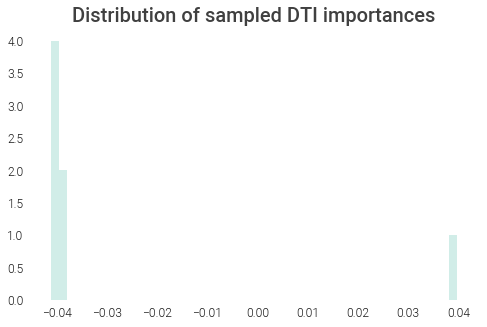

In [272]:
# Plot of resulting distribution
fig,ax = plt.subplots(figsize=(8,5))
sns.distplot(dti_coefs, kde=False, ax=ax);
ax.set_title('Distribution of sampled DTI importances');

### Dive into other importance features

- Have you noticed there are several features that always seem to come up in the most important in this model?
- Let's have a closer look at some of those featues using [ICE (Individual Conditional Expectation)](https://christophm.github.io/interpretable-ml-book/ice.html) plots.


Look at these plots and see what they tell you aboout the model's behavior.  Plot another LICE plot for a different feature! 

(!!!!!!!!!!!! Why are they LICE instead of ICE??)


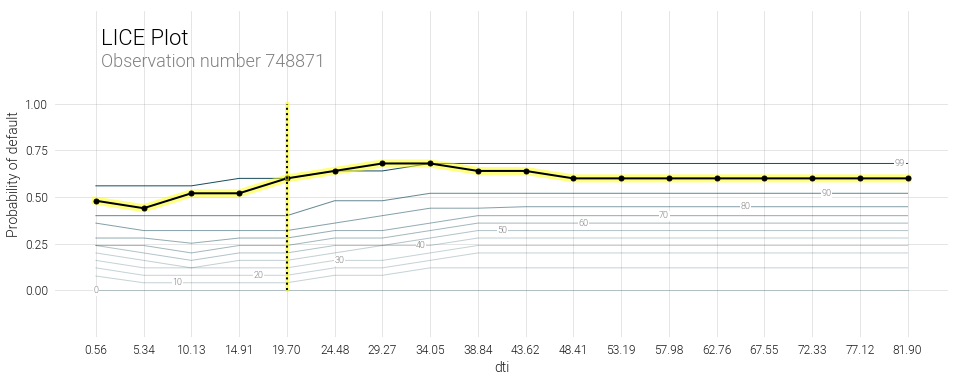

In [273]:
lice_data = x_test.sample(1000, random_state=42)
interp.Lice.plot_lice(lice_data, model, 'dti', 748871);

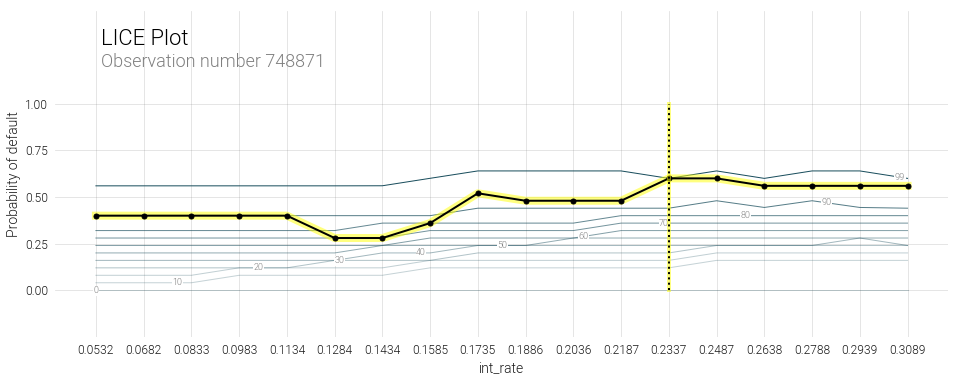

In [274]:
interp.Lice.plot_lice(lice_data, model, 'int_rate', 748871);

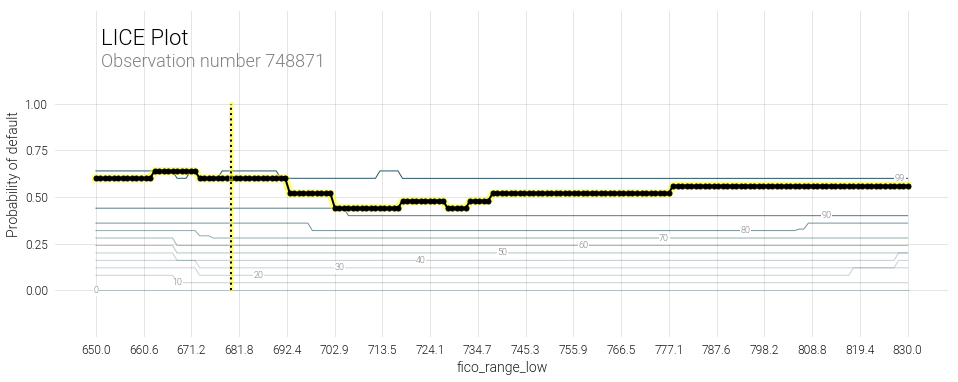

In [275]:
interp.Lice.plot_lice(lice_data, model, 'fico_range_low', 748871);

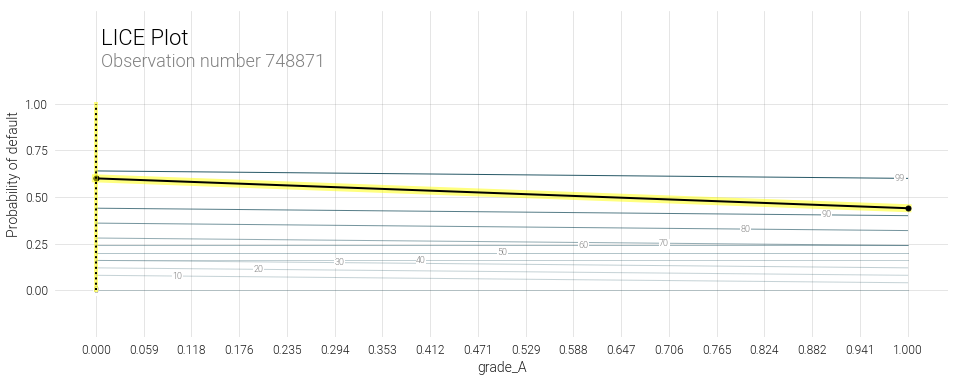

In [276]:
interp.Lice.plot_lice(lice_data, model, 'grade_A', 748871);

### Even more interpretability!
We will look at input gradients and Shapley values (although we only run input gradients due to time) 

Input gradients use finite difference to find the derivative of the model w.r.t the input column while keeping all other features the same.  This measures the univariate impact of each feature for a specific observation.  We can get another mathematical viewpoint into the model's decision at a point and cross-reference with LIME.

#### Input gradients
- Relatively fast to run for single points
- Good mathematical basis
- Intuiative, but not a complete explaination 

#### Shapley values
 - [Shapley values](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) are the gold standard in model interperatability.
 - They are based on a game theoretic approach to feature influence, and they are the only method with firm mathematical foundations.
 - Why don't we just always use them? They are *really* expensive computationally. 

---------------------------------------------

### Input gradients 
We are looking at the input gradient values for the same point that we initially looked at with LIME.  Input gradients also show that raising DTI results in a higher probability of full payment.  This is the same issue we noticed in LIME explaination.   

In [294]:
ig = interp.InputGrad(model, x_test)
ig.ig_explain(ex_idx, num_top_preds=3, h=.1)

Positive_Columns  Positive_Gradients Negative_Columns  Negative_Gradients
0              dti                 0.4       revol_util                -0.8
1      installment                 0.0         int_rate                -0.4
2   age_of_cr_line                 0.0        loan_amnt                 0.0

In [303]:
dti_coefs_ig = []
for idx in x_test[cond].sample(100, random_state=42).index:
    res_df = ig.ig_explain(list(x_test.index).index(idx), num_top_preds=10, h=.1)
    if any(res_df['Positive_Columns']=='dti'):
        dti_coefs_ig.append(res_df[res_df['Positive_Columns']=='dti']['Positive_Gradients'].values[0])
    elif any(res_df['Negative_Columns']=='dti'):
        dti_coefs_ig.append(res_df[res_df['Negative_Columns']=='dti']['Negative_Gradients'].values[0])
    else:
        pass

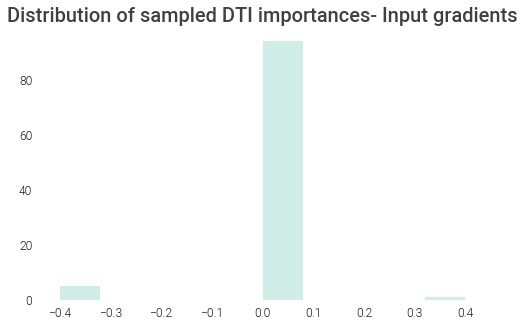

In [304]:
fig,ax = plt.subplots(figsize=(8,5))
sns.distplot(dti_coefs_ig, kde=False, ax=ax);
ax.set_title('Distribution of sampled DTI importances- Input gradients');

In [259]:
# This library is bs - we aren't doing this 
import shap
# shap.initjs()
# shap_data = x_train.sample(10, random_state=42)

# import warnings 
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
  
#     shap_exp = shap.TreeExplainer(model)
#     shap_values = shap_exp.shap_values(shap_data)

#     # visualize the first prediction's explanation
#     print(np.array(shap_values[0][0,:].shape))
#     shap.force_plot(shap_exp.expected_value, shap_values[0][:,0], shap_data.iloc[0,:])

In [264]:
i = np.random.randint(0, x_test.shape[0])
expl = explainer.explain_instance(x_test.values[i,:], model.predict_proba, num_features=5, top_labels=1)
expl.show_in_notebook(show_table=True, show_all=False)

### What could we do to our model to make it more robust?
- We have some issues and potential issues with this model.
- Although DTI is treated correctly most of the time, it seems there are a decent number of instances where it is treated incorrectly. This may or may not be an issue, but it is something to keep in mind.
- The LICE plots reveal troubling model behavior. We see features we know to be linear (like credit score) with significant fluctuations over the feature's range.  Since we know this feature should be monotonic, this behavior should give us pause about the model's robustness.



In [331]:
# Standardize
x_train_std = x_train.copy(deep=True)
x_test_std = x_test.copy(deep=True)

for q_col in quant_cols:
    mean = x_train.loc[:,q_col].mean()
    std = x_train.loc[:,q_col].std()
    x_train_std.loc[:,q_col] = (x_train_std.loc[:,q_col] - mean) /  std
    x_test_std.loc[:,q_col] = (x_test_std.loc[:,q_col] - mean) /  std


In [395]:
model_new = RandomForestClassifier(n_estimators=25, max_depth=12, class_weight=None, \
                                   max_features='log2', random_state=42).fit(x_train_std, y_train)

Accuracy Train: 0.8034; Accuracy Test: 0.7998
AUC train: 0.7451; AUC test: 0.7146


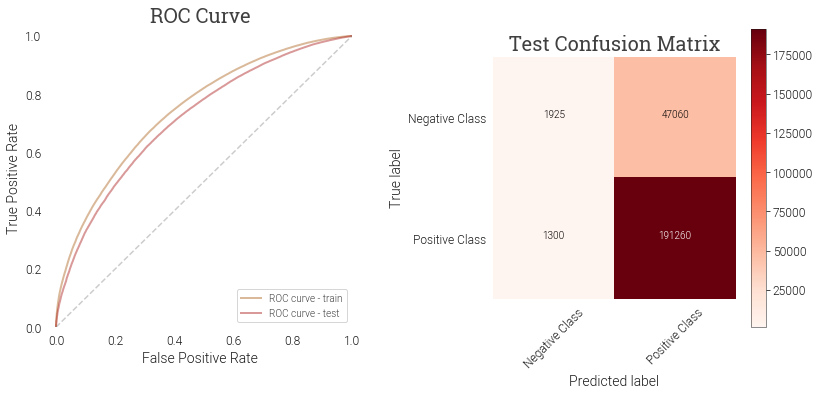

In [396]:
print(f'Accuracy Train: {round(model_new.score(x_train_std, y_train),4)};',\
      f'Accuracy Test: {round(model_new.score(x_test_std, y_test),4)}')
eq.model.model_analysis(model_new, x_train_std, y_train, x_test_std, y_test, style='deck', figsize=(12,6));

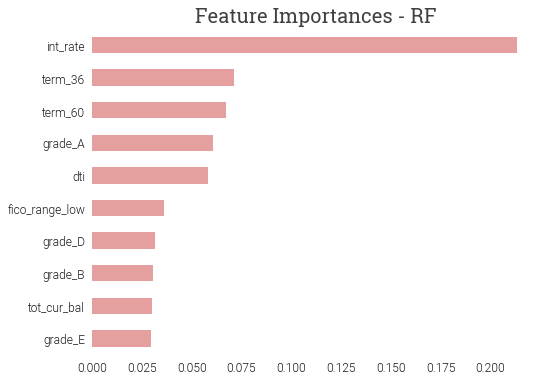

In [397]:
# fig, ax = plt.subplots(figsize=(8,6))
# feat_importances = pd.Series(model_new.feature_importances_, index=x_train.columns)
# ax = feat_importances.nlargest(10).sort_values().plot(kind='barh', color='r', alpha=0.6, ax=ax)
# ax.set_title('Feature Importances - RF');

# Eqtools version 
fig, ax = plt.subplots(figsize=(8,6))
eq.viz.explain_model(model_new, x_train.columns, style='deck', ax=ax);

### LIME 
- The instance we looked at earlier still has a questionable DTI importance, but the distribution of DTI importances looks better

In [398]:
# LIME 
explainer_std = LimeTabularExplainer(x_train_std.values, feature_names=x_train.columns, training_labels=y_train,\
                                 class_names=['Default', 'Fully Paid'], kernel_width=4, random_state=42)

# Show a prediction
ex_idx = 195950
pred = model_new.predict(x_test_std.values[ex_idx,:].reshape(1,-1))
print('The true result is:','Fully Paid' if y_test.values[ex_idx]==1 else 'Default')
print('The predicted result is:','Fully Paid' if pred==1 else 'Default')

expl = explainer_std.explain_instance(x_test_std.values[ex_idx,:],  model_new.predict_proba, \
                                      num_features=6, top_labels=1)
expl.show_in_notebook(show_table=True, show_all=False)

The true result is: Fully Paid
The predicted result is: Default


### Distribtuion of DTI importances 

- This looks better because all the importances are negative (meaning high DTI contributes to probability of default)

In [403]:
dti_coefs_std = []
for idx in x_test_std[cond].sample(7, random_state=42).index:
    expl = explainer_std.explain_instance(x_test_std.loc[idx,:].values, model_new.predict_proba, \
                                      num_features=6, top_labels=1)
    pred = model_new.predict(x_test_std.loc[idx,:].values.reshape(1,-1))[0]
    dti_coefs_std.append([i[1] for i in expl.as_list(label=pred) if 'dti' in i[0]][0])
    # expl.show_in_notebook(show_table=True, show_all=False)

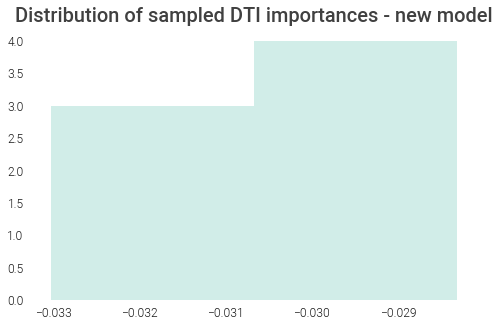

In [404]:
fig,ax = plt.subplots(figsize=(8,5))
sns.distplot(dti_coefs_std, kde=False, ax=ax);
ax.set_title('Distribution of sampled DTI importances - new model');

### LICE plots 
- Our new model looks better than the old one. Features we know should be monotonic are monotonic.

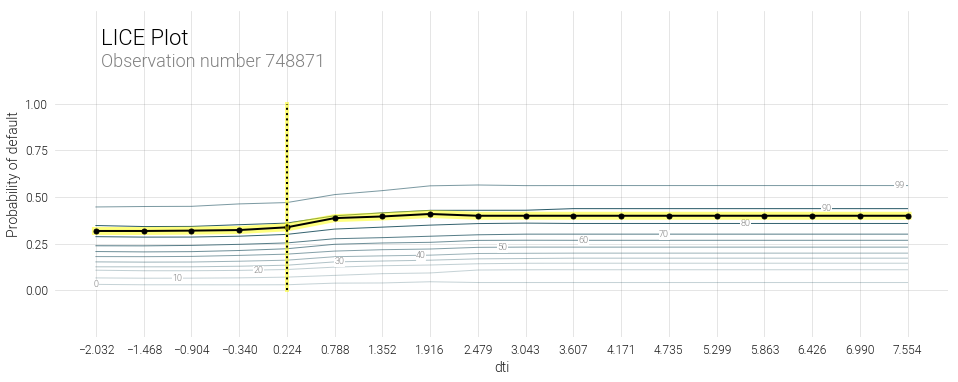

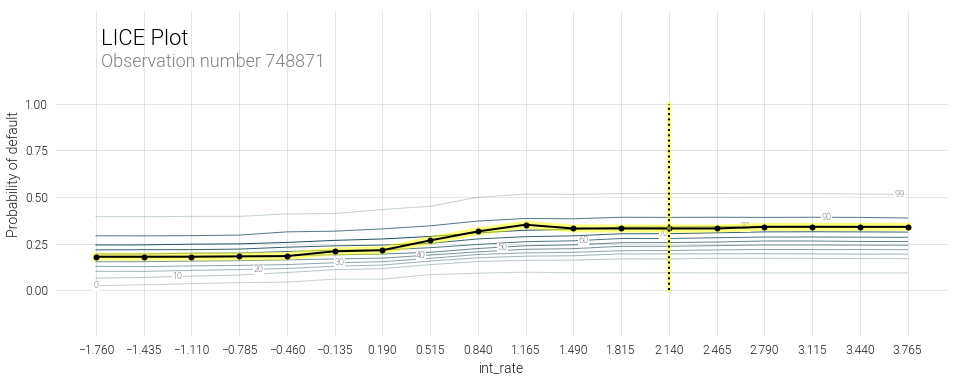

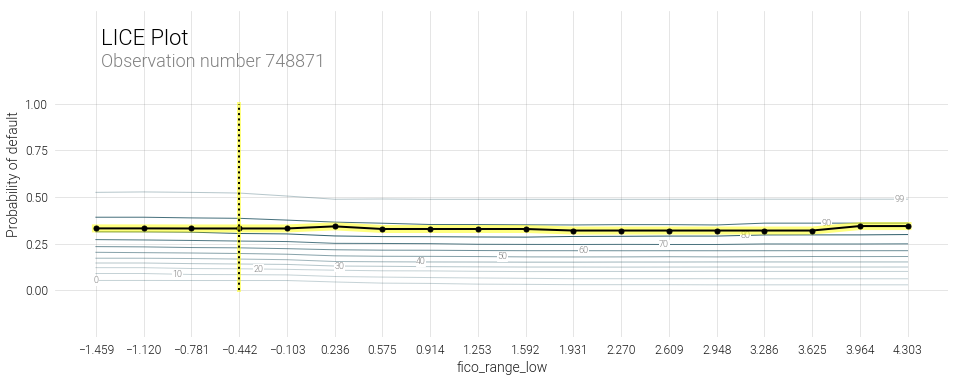

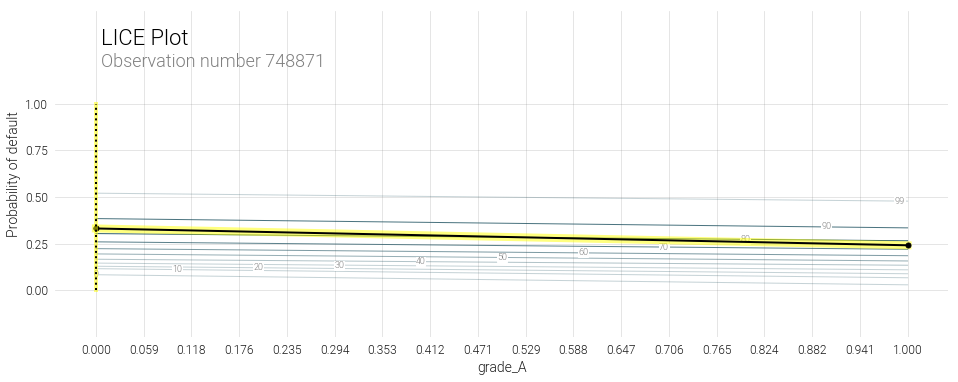

In [402]:
lice_data_std = x_test_std.sample(1000, random_state=42)
for col in ['dti', 'int_rate', 'fico_range_low', 'grade_A']:
    interp.Lice.plot_lice(lice_data_std, model_new, col, 748871);
    plt.show()

## Fairness! 
- Although a model is well-founded and predicts well, it can still be biased without us knowing
- There are several ways to measure the fairness of a model
